In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the train_dataset and 20% of the data as the test_dataset.

pop off the "expenses" column from these datasets to create new datasets called train_labels and test_labels. Use these labels when training your model.

Create a model and train it with the train_dataset. Run the final cell in this notebook to check your model. The final cell will use the unseen test_dataset to check how well the model generalizes.

To pass the challenge, model.evaluate must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the test_dataset and graph the results.


In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [4]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
df = pd.read_csv('insurance.csv')
df.tail()

--2025-08-02 17:04:00--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.1’

insurance.csv.1     100%[===================>]  49.09K  --.-KB/s    in 0.005s  

2025-08-02 17:04:00 (9.20 MB/s) - ‘insurance.csv.1’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [5]:
#check missing values
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
expenses,0


In [6]:
#handle categorical values
df.dtypes

,0
age,int64
sex,object
bmi,float64
children,int64
smoker,object
region,object
expenses,float64


In [7]:
#regions
df.region.value_counts()

,count
region,
southeast,364
southwest,325
northwest,325
northeast,324


In [8]:

df = df.join(pd.get_dummies(df.region, prefix='region')).drop('region', axis=1)
df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.9,0,yes,16884.92,False,False,False,True
1,18,male,33.8,1,no,1725.55,False,False,True,False
2,28,male,33.0,3,no,4449.46,False,False,True,False
3,33,male,22.7,0,no,21984.47,False,True,False,False
4,32,male,28.9,0,no,3866.86,False,True,False,False


In [9]:
#sex
df.sex.value_counts()

,count
sex,
male,676
female,662


Linear regression models can't handle string data directly. So:

* Categorical variables must be converted to numerical form.

* This example uses Label Encoding (mapping categories to integers), which is fine for binary features like sex.

In [10]:

labels = {}

values        = df.sex.astype('category')
labels['sex'] = values.cat.categories
df['sex']     = values.cat.codes            #Replaces the original sex column with its encoded numeric codes (0 for female, 1 for male, typically)

df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,yes,16884.92,False,False,False,True
1,18,1,33.8,1,no,1725.55,False,False,True,False
2,28,1,33.0,3,no,4449.46,False,False,True,False
3,33,1,22.7,0,no,21984.47,False,True,False,False
4,32,1,28.9,0,no,3866.86,False,True,False,False


In [11]:
#smoker
df.smoker.value_counts()

,count
smoker,
no,1064
yes,274


In [12]:
values           = df.smoker.astype('category')
labels['smoker'] = values.cat.categories
df['smoker']     = values.cat.codes

df.head()

,age,sex,bmi,children,smoker,expenses,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.9,0,1,16884.92,False,False,False,True
1,18,1,33.8,1,0,1725.55,False,False,True,False
2,28,1,33.0,3,0,4449.46,False,False,True,False
3,33,1,22.7,0,0,21984.47,False,True,False,False
4,32,1,28.9,0,0,3866.86,False,True,False,False


In [13]:
labels

{'sex': Index(['female', 'male'], dtype='object'),
 'smoker': Index(['no', 'yes'], dtype='object')}

Explore data

df.corr()
Computes the pairwise correlation between all numeric columns in df.

Returns a square matrix (DataFrame) showing how strongly each pair of features is linearly related.

Values range from:

+1.00: perfect positive correlation

-1.00: perfect negative correlation

0.00: no linear correlation

sns.heatmap(...)
Plots a heatmap of the correlation matrix.

Parameters used:
annot=True: Writes the correlation values inside each cell.

fmt='.2f': Formats those numbers to 2 decimal places.

<Axes: >

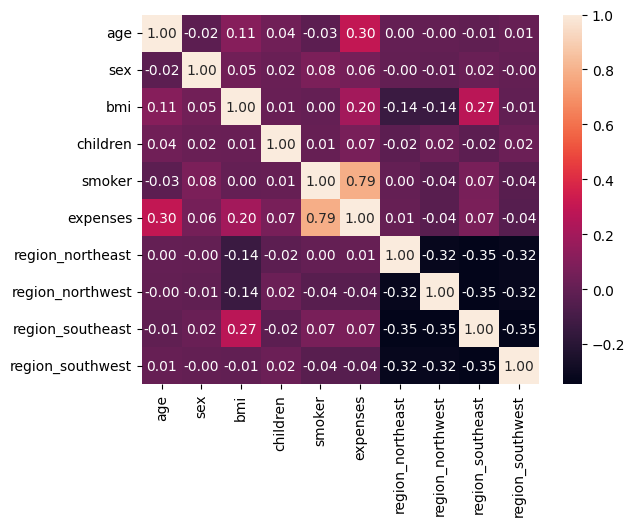

In [15]:
import seaborn as sns
sns.heatmap(df.corr(), annot=True, fmt='.2f')

In [16]:
df.drop(['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest'], axis=1, inplace=True)

In [17]:
df.drop(['sex', 'children'], axis=1, inplace=True)

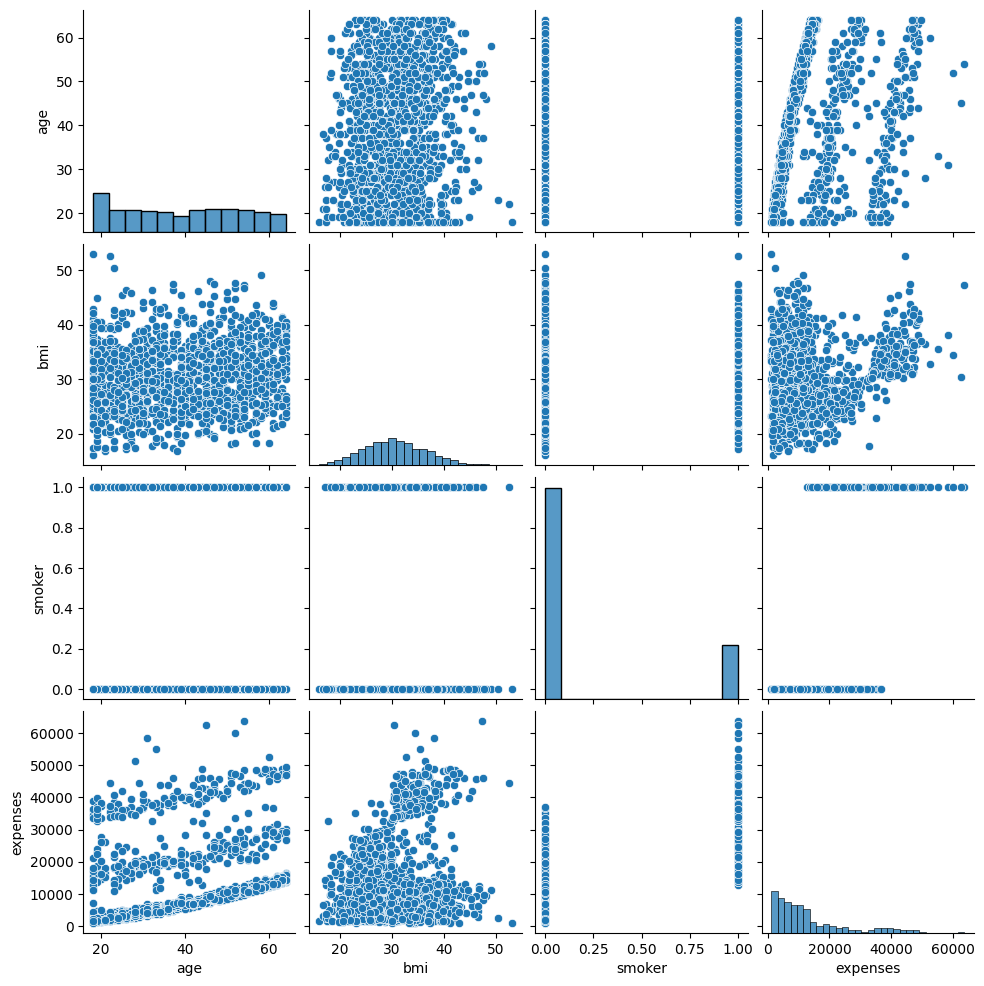

In [18]:
sns.pairplot(df)

Split Data


In [19]:
# shuffle the rows, just in case
df = df.sample(frac=1)

In [20]:
size          = int(len(df) * .2)
train_dataset = df[:-size]
test_dataset  = df[-size:]

print(len(df), len(train_dataset), len(test_dataset))

1338 1071 267


In [31]:
print(df.columns.tolist())

['age', 'bmi', 'smoker', 'expenses']


In [37]:
train_dataset = df.copy()

train_labels  = train_dataset['expenses']
train_dataset = train_dataset.drop('expenses', axis=1)


In [41]:
test_dataset = df.copy()

test_labels   = test_dataset['expenses']
test_dataset  = test_dataset.drop('expenses', axis=1)

Build Model


In [42]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(train_dataset.keys()),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(
    optimizer= tf.keras.optimizers.RMSprop(0.05),
    loss='mse',
    metrics=['mae', 'mse']
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 3)              │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,493 (17.55 KB)

 Trainable params: 4,487 (17.53 KB)

 Non-trainable params: 6 (24.00 B)

In [43]:
# taken from tfdocs.modeling.EpochDots
class EpochDots(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0:
      print()
      print('Epoch: {:d}, '.format(epoch), end='')
      for name, value in sorted(logs.items()):
        print('{}:{:0.4f}'.format(name, value), end=', ')
      print()

    print('.', end='')


r = model.fit(train_dataset, train_labels, epochs=500,
              verbose=0, callbacks=[EpochDots()])


Epoch: 0, loss:110281920.0000, mae:6427.2354, mse:110281920.0000, 
....................................................................................................
Epoch: 100, loss:25260892.0000, mae:3052.7959, mse:25260892.0000, 
....................................................................................................
Epoch: 200, loss:24469908.0000, mae:2980.1858, mse:24469908.0000, 
....................................................................................................
Epoch: 300, loss:23519724.0000, mae:2893.5964, mse:23519724.0000, 
....................................................................................................
Epoch: 400, loss:23988560.0000, mae:2952.1702, mse:23988560.0000, 
....................................................................................................

In [44]:
res = model.evaluate(test_dataset, test_labels, verbose=2)
print(res)

42/42 - 0s - 6ms/step - loss: 21123176.0000 - mae: 2587.9519 - mse: 21123176.0000
[21123176.0, 2587.951904296875, 21123176.0]


Challenge


42/42 - 0s - 2ms/step - loss: 21123176.0000 - mae: 2587.9519 - mse: 21123176.0000
Testing set Mean Abs Error: 2587.95 expenses
You passed the challenge. Great job!
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


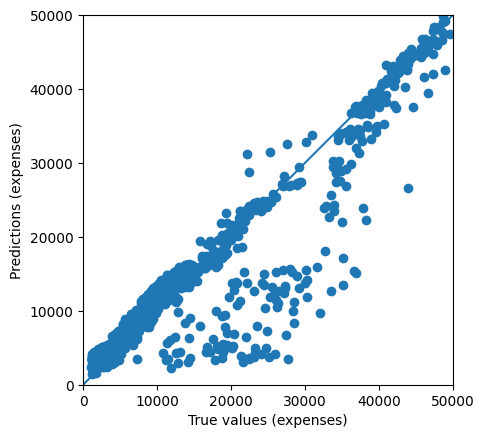

In [45]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
